In [107]:
import time
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import cv2
import numpy as np
import os
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm
from glob import glob
from pathlib import Path

In [108]:
import face_alignment

# Load pretrained landmark model (68 points, 2D)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [109]:
device

'cuda'

In [110]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, device=device, flip_input=False)


In [111]:
def create_nose_mask(image_path, save_path, log):
    try:
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        preds = fa.get_landmarks(img_rgb)
        if preds is None:
            return False
            
    except Warning as w:  # Catch warnings as exceptions
        return False

    landmarks = preds[0]
    nose_points = landmarks[27:36]  # indexes 27–35 in 0-based Python index

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(nose_points), 255)

    cv2.imwrite(save_path, mask)
    return True

In [112]:
!pwd

/workspace


In [113]:
# Example usage
import logging
import warnings

input_folder = "/workspace/processed/train/A"
test_folder = "/workspace/processed/val/A"
mask_folder = "/workspace/nose_mask"
test_mask_folder = "/workspace/test_nose_mask"
os.makedirs(mask_folder, exist_ok=True)
os.makedirs(test_mask_folder, exist_ok=True)

warnings.filterwarnings("error", message="No faces were detected.")

if not any(os.scandir(mask_folder)):
    for file in os.listdir(input_folder):
        if file.lower().endswith(('.jpeg', '.png')):
            create_nose_mask(os.path.join(input_folder, file),
                             os.path.join(mask_folder, file), logging)

if not any(os.scandir(test_mask_folder)):
    for file in os.listdir(test_folder):
        if file.lower().endswith(('.jpeg', '.png')):
            create_nose_mask(os.path.join(test_folder, file),
                             os.path.join(test_mask_folder, file), logging)

In [114]:
# !ls -lh /workspace/nose_mask

In [115]:
def img_to_patches(x, patch_size):
    # x: (B, C, H, W)
    B, C, H, W = x.shape
    assert H % patch_size == 0 and W % patch_size == 0
    ph, pw = patch_size, patch_size
    nh, nw = H // ph, W // pw
    x = x.reshape(B, C, nh, ph, nw, pw)
    x = x.permute(0,2,4,3,5,1).reshape(B, nh*nw, ph*pw*C)  # (B, N, patch_dim)
    return x, (nh, nw)

In [116]:
def patches_to_img(patches, patch_size, nh_nw, C):
    # patches: (B, N, patch_dim)
    B, N, D = patches.shape
    nh, nw = nh_nw
    ph = pw = patch_size
    x = patches.reshape(B, nh, nw, ph, pw, C).permute(0,5,1,3,2,4).reshape(B, C, nh*ph, nw*pw)
    return x

In [117]:
def mask_to_patch_mask(mask, patch_size):
    # mask: (B,1,H,W) binary [0,1]
    B, _, H, W = mask.shape
    ph = pw = patch_size
    nh, nw = H//ph, W//pw
    mask = mask.reshape(B, 1, nh, ph, nw, pw)
    mask = mask.mean(dim=(3,5))  # (B,1,nh,nw)
    patch_mask = (mask.view(B, nh*nw) > 0.1).float()  # (B, N)
    return patch_mask  # 1 where patch contains nos

In [118]:
def validate_files(img_dir, mask_dir, target_dir):
    img_dir, mask_dir, target_dir = map(Path, (img_dir, mask_dir, target_dir))
    valid_files = []
    for f in os.listdir(img_dir):
        if f.startswith("pre"):
            target_f = f.replace("pre", "post", 1)  # replace only first occurrence
            if (img_dir/f).exists() and (mask_dir/f).exists() and (target_dir/target_f).exists():
                valid_files.append((f, target_f))  # store input-target pair
    return valid_files

In [119]:
from pathlib import Path
from torch.utils.data import Dataset
import torch, cv2
import numpy as np

class NoseFolderDataset(Dataset):
    def __init__(self, img_dir, mask_dir, target_dir, size=256):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.target_dir = Path(target_dir)
        self.size = size
        self.file_pairs = validate_files(img_dir, mask_dir, target_dir)  # [(img_name, tgt_name), ...]

    def __len__(self):
        return len(self.file_pairs)

    def _read_rgb(self, path):
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(f"Could not read image: {path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_AREA)
        return img

    def _read_mask(self, path):
        m = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if m is None:
            raise FileNotFoundError(f"Could not read mask: {path}")
        m = cv2.resize(m, (self.size, self.size), interpolation=cv2.INTER_NEAREST)
        m = (m > 127).astype(np.uint8)  # 0/1
        return m

    def __getitem__(self, idx):
        fname, target_f = self.file_pairs[idx]
        img_path    = self.img_dir / fname
        mask_path   = self.mask_dir / fname
        target_path = self.target_dir / target_f

        img    = self._read_rgb(img_path)      # (H,W,3) RGB uint8
        target = self._read_rgb(target_path)   # (H,W,3) RGB uint8
        mask   = self._read_mask(mask_path)    # (H,W)    0/1

        # to tensors in [0,1]
        img_t    = torch.from_numpy(img).permute(2,0,1).float() / 255.0   # (3,H,W)
        target_t = torch.from_numpy(target).permute(2,0,1).float() / 255.0
        mask_t   = torch.from_numpy(mask).unsqueeze(0).float()            # (1,H,W) in {0,1}

        x = torch.cat([img_t, mask_t], dim=0)  # (4,H,W)

        return {
            "input": x,
            "target": target_t,
            "mask": mask_t,
            "input_file": str(img_path),
            "mask_file": str(mask_path),
            "target_file": str(target_path),
        }

In [120]:
IMG_DIR    = "/workspace/processed/train/A"
MASK_DIR   = "/workspace/nose_mask"
TARGET_DIR = "/workspace/processed/train/B"
ds = NoseFolderDataset(IMG_DIR, MASK_DIR, TARGET_DIR, size=256)

# check first sample
sample = ds[0]
print(sample["input"].shape, sample["target"].shape, sample["mask"].min().item(), sample["mask"].max().item())


torch.Size([4, 256, 256]) torch.Size([3, 256, 256]) 0.0 1.0


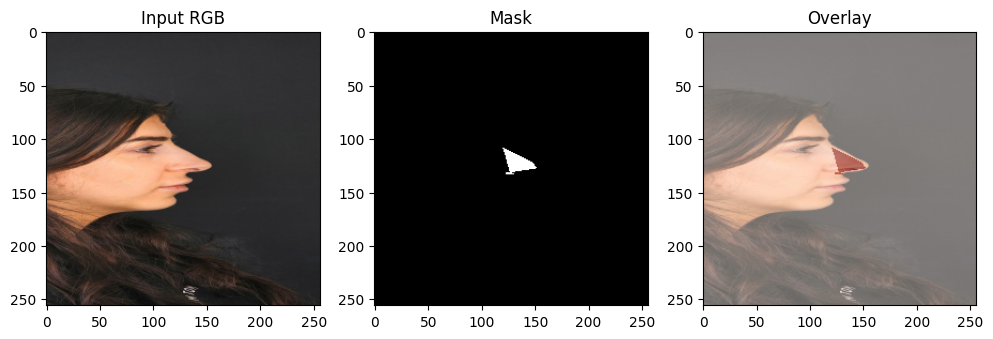

In [121]:
import matplotlib.pyplot as plt

sample = ds[0]
inp   = sample["input"][:3]   # take only RGB
mask  = sample["mask"][0]     # (H,W)
tgt   = sample["target"]

inp_np  = inp.permute(1,2,0).numpy()
tgt_np  = tgt.permute(1,2,0).numpy()
mask_np = mask.numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(inp_np); plt.title("Input RGB")
plt.subplot(1,3,2); plt.imshow(mask_np, cmap="gray"); plt.title("Mask")
plt.subplot(1,3,3); plt.imshow(inp_np); plt.imshow(mask_np, cmap="Reds", alpha=0.4); plt.title("Overlay")
plt.show()

In [122]:
class PatchEmbed(nn.Module):
    def __init__(self, in_ch, embed_dim, patch_size):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Linear((patch_size*patch_size*in_ch), embed_dim)

    def forward(self, x):
        # x: (B, C, H, W)
        patches, (nh, nw) = img_to_patches(x, self.patch_size)  # (B, N, patch_dim)
        x = self.proj(patches)  # (B, N, embed_dim)
        return x, (nh, nw)

In [123]:
class PatchUnembed(nn.Module):
    def __init__(self, out_ch, patch_size, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.rev = nn.Linear(embed_dim, patch_size*patch_size*out_ch)

    def forward(self, x, nh_nw, out_ch):
        # x: (B, N, embed_dim)
        patches = self.rev(x)  # (B, N, patch_dim)
        img = patches_to_img(patches, self.patch_size, nh_nw, out_ch)
        return img  # (B, out_ch, H, W)

In [124]:
class MHA_with_bias(nn.Module):
    def __init__(self, embed_dim, num_heads, attn_dropout=0.0):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=attn_dropout, batch_first=True)
        # We'll manually add bias to attn weights via key_padding_mask-like approach using attn_mask arg.
    def forward(self, x, attn_bias=None):
        # x: (B, N, D)
        B, N, D = x.shape
        # attn_bias expected shape: (B, N, N) or None. MultiheadAttention accepts attn_mask of shape (N, N) or (B*num_heads, N, N) in latest versions.
        # We'll collapse batch and apply per-sample attention via loop for clarity (small overhead).
        outputs = []
        for b in range(B):
            xb = x[b:b+1]  # (1,N,D)
            # attn_mask for nn.MultiheadAttention should be (N,N) where True/float(-inf) masks, but PyTorch expects float mask with -inf in positions to mask.
            attn_mask_b = None
            if attn_bias is not None:
                # attn_bias[b]: (N,N) float where large negative values encourage zero attention.
                attn_mask_b = attn_bias[b].to(x.device)  # float mask
            out_b, _ = self.mha(xb, xb, xb, attn_mask=attn_mask_b)
            outputs.append(out_b)
        out = torch.cat(outputs, dim=0)
        return out


In [125]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MHA_with_bias(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim*mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim*mlp_ratio), embed_dim)
        )

    def forward(self, x, attn_bias=None):
        x = x + self.attn(self.norm1(x), attn_bias=attn_bias)
        x = x + self.mlp(self.norm2(x))
        return x

In [126]:
import torch, torch.nn as nn
import torch.nn.functional as F

class ConvDecoder(nn.Module):
    def __init__(self, in_dim, out_ch=3, up_factor=8):
        super().__init__()
        # in: (B, in_dim, nh, nw). We upsample by `up_factor` to H,W
        self.body = nn.Sequential(
            nn.Conv2d(in_dim, 256, 3, padding=1), nn.GELU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, 3, padding=1),   nn.GELU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, 3, padding=1),    nn.GELU(),
            nn.Upsample(scale_factor=max(1, up_factor//4), mode='bilinear', align_corners=False),
            nn.Conv2d(64, out_ch, 3, padding=1)
        )
        # Final residual is bounded so training is stable (tanh * scale)
        self.res_scale = 0.25

    def forward(self, feat):  # feat: (B, D, nh, nw)
        delta = self.body(feat)                 # (B, 3, H, W)
        return torch.tanh(delta) * self.res_scale

class NoseTransformer(nn.Module):
    def __init__(self, in_ch=4, out_ch=3, embed_dim=512, patch_size=8, depth=6, num_heads=8,
                 bias_pos=+1.0, bias_neg=-0.5):
        super().__init__()
        self.patch_size  = patch_size
        self.embed_dim   = embed_dim
        self.out_ch      = out_ch
        self.bias_pos    = bias_pos   # encourage nose↔nose
        self.bias_neg    = bias_neg   # discourage nose→non-nose (soft, not -inf)

        self.patch_embed = PatchEmbed(in_ch, embed_dim, patch_size)
        self.pos_embed   = None  # lazily init for fixed N
        self.blocks      = nn.ModuleList([TransformerBlock(embed_dim, num_heads) for _ in range(depth)])
        # Replace linear unembed with conv decoder
        self.decoder     = ConvDecoder(in_dim=embed_dim, out_ch=out_ch, up_factor=patch_size)

    def _build_attn_bias(self, patch_mask):
        # patch_mask: (B, N) in {0,1}; build soft additive bias (B, N, N)
        # Encourage nose↔nose (+), discourage nose->non-nose (−), neutral otherwise
        # Vectorized: q is nose (B,N,1), k is non-nose (B,1,N)
        pm = patch_mask.float()
        same = torch.einsum('bi,bj->bij', pm, pm)                  # 1 when both nose
        q_is_nose = pm.unsqueeze(2)                                # (B,N,1)
        k_not_nose = (1.0 - pm).unsqueeze(1)                       # (B,1,N)
        nose_to_non = q_is_nose * k_not_nose                       # (B,N,N)
        attn_bias = self.bias_pos * same + self.bias_neg * nose_to_non
        return attn_bias

    def forward(self, inp, patch_mask=None):
        """
        inp: (B, 4, H, W)  [RGB + mask]
        patch_mask: (B, N) or None
        """
        B, _, H, W = inp.shape
        x, (nh, nw) = self.patch_embed(inp)        # (B, N, D)
        N = x.shape[1]

        # Positional embeddings (assumes fixed H,W during training)
        if self.pos_embed is None or self.pos_embed.shape[1] != N:
            self.pos_embed = nn.Parameter(torch.zeros(1, N, self.embed_dim, device=x.device))
            nn.init.trunc_normal_(self.pos_embed, std=0.02)
        x = x + self.pos_embed

        # Attention bias
        attn_bias = None
        if patch_mask is not None:
            attn_bias = self._build_attn_bias(patch_mask)  # (B, N, N)

        # Transformer encoder
        for blk in self.blocks:
            x = blk(x, attn_bias=attn_bias)                # (B, N, D)

        # Tokens -> 2D feature map (no linear unembed)
        feat = x.transpose(1, 2).reshape(B, self.embed_dim, nh, nw)  # (B, D, nh, nw)

        # Conv decoder outputs a residual
        delta = self.decoder(feat)                          # (B, 3, H, W)

        # Residual-in-mask fusion
        rgb  = inp[:, :3]                                   # (B,3,H,W)
        m3   = inp[:, 3:4].repeat(1, 3, 1, 1)              # (B,3,H,W)
        out  = torch.clamp(rgb + delta * m3, 0, 1)         # only change inside mask
        return out

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import lpips

class MaskedPerceptualCombo(nn.Module):
    """
    Combined masked perceptual loss:
      - VGG feature L1 on selected layers (masked, area-normalized)
      - LPIPS (alex/vgg/squeeze) with spatial map (masked, area-normalized)

    Expects pred/target in [0,1]. Handles ImageNet and [-1,1] normalization internally.
    """
    def __init__(
        self,
        vgg_layer_ids=(3, 8, 15, 22),
        vgg_layer_weights=(1.0, 0.5, 0.25, 0.25),
        vgg_weight=0.2,             # tune: 0.1–0.4
        lpips_net="alex",           # "alex" (fast), "vgg" (heavier), "squeeze"
        lpips_weight=1.0,           # tune: 0.5–1.0
    ):
        super().__init__()

        # --- VGG feature extractor ---
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features
        self.vgg = vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad = False
        self.vgg_layer_ids = set(vgg_layer_ids)
        self.vgg_layer_w = {i: w for i, w in zip(vgg_layer_ids, vgg_layer_weights)}
        self.vgg_weight = float(vgg_weight)

        # ImageNet normalization buffers
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)
        self.register_buffer("imgnet_mean", mean)
        self.register_buffer("imgnet_std", std)

        # --- LPIPS (spatial map) ---
        # spatial=True gives per-location distances (B,1,h,w) so we can mask properly.
        self.lpips = lpips.LPIPS(net=lpips_net, spatial=True)
        self.lpips.eval()
        for p in self.lpips.parameters():
            p.requires_grad = False
        self.lpips_weight = float(lpips_weight)

    def _norm_imgnet(self, x01):
        # x01: [0,1] -> ImageNet normalized
        x01 = x01.clamp(0,1)
        return (x01 - self.imgnet_mean) / self.imgnet_std

    def _to_m11(self, x01):
        # x01: [0,1] -> [-1,1] for LPIPS
        return x01.clamp(0,1) * 2.0 - 1.0

    def _mask_reduce(self, diff_map, mask):
        """
        diff_map: (B,C,h,w) or (B,1,h,w)
        mask:     (B,1,H,W) in {0,1}  -> downsampled to (B,1,h,w) and area-normalized
        Returns mean over masked area (sum(mask*diff)/sum(mask)).
        """
        if mask is None:
            # plain mean over spatial (and channel if needed)
            return diff_map.abs().mean()

        B, _, h, w = diff_map.shape
        m = F.interpolate(mask.float(), size=(h, w), mode="area").clamp(0,1)  # (B,1,h,w)
        num = (m * diff_map.abs()).sum()
        den = m.sum().clamp_min(1.0)
        return num / den

    def forward(self, pred01, target01, mask=None):
        """
        pred01, target01: (B,3,H,W) in [0,1]
        mask: (B,1,H,W) in {0,1} or None
        Returns: total_loss, dict with 'vgg', 'lpips'
        """
        # ---------- VGG masked feature L1 ----------
        x = self._norm_imgnet(pred01)
        y = self._norm_imgnet(target01)

        loss_vgg = 0.0
        feat_x, feat_y = x, y
        # We need grads w.r.t. pred; VGG is frozen but forward must allow grad flow.
        for i, layer in enumerate(self.vgg):
            feat_x = layer(feat_x)
            feat_y = layer(feat_y)
            if i in self.vgg_layer_ids:
                # L1 feature difference per layer
                diff = (feat_x - feat_y)
                layer_loss = self._mask_reduce(diff, mask)
                loss_vgg = loss_vgg + self.vgg_layer_w.get(i, 1.0) * layer_loss

        # ---------- LPIPS masked ----------
        # LPIPS expects [-1,1]; set spatial=True so we can mask
        px = self._to_m11(pred01)
        py = self._to_m11(target01)
        # (B,1,h,w) distances (already positive); don't abs() again
        d_spatial = self.lpips(px, py, normalize=False)  # normalize=False because we already mapped to [-1,1]
        # mask-reduce on LPIPS map
        loss_lpips = self._mask_reduce(d_spatial, mask)

        # ---------- combine ----------
        total = self.vgg_weight * loss_vgg + self.lpips_weight * loss_lpips
        return total, {"vgg": loss_vgg.detach(), "lpips": loss_lpips.detach()}

In [134]:
import os, torch
import torch.nn.functional as F
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from tqdm import tqdm


def erode_mask(mask, k=5, iters=1):
    # mask: (B,1,H,W) float {0,1}
    x = 1.0 - mask
    for _ in range(iters):
        x = F.max_pool2d(x, kernel_size=k, stride=1, padding=k//2)
    return 1.0 - x

    

def dilate_mask(mask, k=3, iters=2):
    # mask: (B,1,H,W) float in {0,1}
    out = mask
    for _ in range(iters):
        out = F.max_pool2d(out, kernel_size=k, stride=1, padding=k//2)
    return out

def to_luma(x):  # x in [0,1], (B,3,H,W)
    r,g,b = x[:,0:1], x[:,1:2], x[:,2:3]
    return 0.299*r + 0.587*g + 0.114*b

def grad_map(x):  # x in [0,1], (B,3,H,W)
    xY = to_luma(x)
    kx = xY.new_tensor([[1,0,-1],[2,0,-2],[1,0,-1]]).view(1,1,3,3)/8.0
    ky = xY.new_tensor([[1,2,1],[0,0,0],[-1,-2,-1]]).view(1,1,3,3)/8.0
    gx = F.conv2d(xY, kx, padding=1)
    gy = F.conv2d(xY, ky, padding=1)
    return gx.abs() + gy.abs()

def psnr(pred, target, eps=1e-8):
    mse = F.mse_loss(pred, target)
    return 20.0 * torch.log10(1.0 / torch.sqrt(mse + eps))

@torch.no_grad()
def validate_epoch(model, dataloader, device, patch_size):
    model.eval()
    total_l1m = total_l1g = total_psnr = 0.0
    total_chg_in_mask = total_l1_in = 0.0
    n = 0

    for batch in tqdm(dataloader, desc="valid", leave=False):
        inp    = batch["input"].to(device)
        mask   = batch["mask"].to(device)
        target = batch["target"].to(device)
        patch_mask = mask_to_patch_mask(mask, patch_size)

        pred = model(inp, patch_mask=patch_mask).clamp(0,1)

        l1m = ((pred - target).abs() * mask).sum() / (mask.sum() + 1e-6)
        l1g = F.l1_loss(pred, target)
        p   = psnr(pred, target)
        chg_inside = ((pred - inp[:, :3]).abs() * mask).sum() / (mask.sum() + 1e-6)
        l1_in = F.l1_loss(pred, inp[:, :3])

        bsz = inp.size(0)
        total_l1m        += l1m.item() * bsz
        total_l1g        += l1g.item() * bsz
        total_psnr       += p.item()   * bsz
        total_chg_in_mask+= chg_inside.item() * bsz
        total_l1_in      += l1_in.item() * bsz
        n += bsz

    return {
        "l1_mask":   total_l1m / max(1,n),
        "l1_global": total_l1g / max(1,n),
        "psnr":      total_psnr / max(1,n),
        "chg_in_mask": total_chg_in_mask / max(1,n),
        "l1_in":     total_l1_in / max(1,n),
    }

def train(
    model,
    train_loader,
    val_loader,
    device,
    patch_size=8,
    epochs=40,
    lr=2e-4,
    lambda_global=0.1,      # kept for config completeness
    lambda_percep=0.2,      # used only if use_lpips=False
    out_dir="./checkpoints_v2",
    grad_accum_steps=1,
    amp=True,
    save_best_on="l1_mask"   # or "psnr"
):
    os.makedirs(out_dir, exist_ok=True)
    model.to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=lr*0.1)
    scaler = GradScaler(enabled=amp)

    # perceptual loss
    if use_lpips:
        combo = MaskedPerceptualCombo(vgg_weight=0.1, lpips_weight=0.5).to(device)  # tamer weights
        for p in combo.parameters(): p.requires_grad_(False)
        perceptual_fn = combo  # returns (total, dict)
    else:
        perceptual_fn = PerceptualLoss(weight=lambda_percep).to(device)
        for p in perceptual_fn.parameters(): p.requires_grad_(False)

    best_metric = float("inf") if save_best_on=="l1_mask" else -float("inf")
    best_path = None

    for epoch in range(1, epochs+1):
        model.train()
        running = {
            "l1m":0.0, "l1g":0.0, "perc":0.0, "loss":0.0,
            "l1_in":0.0, "chg_in_mask":0.0, "l_out_id":0.0, "pen_change":0.0
        }
        seen = 0

        pbar = tqdm(train_loader, desc=f"train {epoch}/{epochs}")
        opt.zero_grad(set_to_none=True)

        for step, batch in enumerate(pbar, start=1):
            inp    = batch["input"].to(device)     # (B,4,H,W)
            mask   = batch["mask"].to(device)      # (B,1,H,W)
            target = batch["target"].to(device)    # (B,3,H,W)
            patch_mask = mask_to_patch_mask(mask, patch_size)

            with autocast(device_type=("cuda" if torch.cuda.is_available() else "cpu"), enabled=amp):
                pred = model(inp, patch_mask=patch_mask).clamp(0,1)

                use_mask = dilate_mask(mask, k=3, iters=2)           # for inside supervision
                outside  = 1.0 - erode_mask(mask, k=7, iters=2)      # for outside identity

                l1_mask   = ((pred - target).abs() * use_mask).sum() / (use_mask.sum() + 1e-6)
                l1_global = F.l1_loss(pred, target)
                l_out_id  = ((pred - inp[:, :3]).abs() * outside).sum() / (outside.sum() + 1e-6)

                Yp, Yi, Yt = to_luma(pred), to_luma(inp[:, :3]), to_luma(target)
                l1_mask_Y  = ((Yp - Yt).abs() * use_mask).sum() / (use_mask.sum()+1e-6)
                edge_loss  = ((grad_map(pred) - grad_map(target)).abs() * use_mask).sum() / (use_mask.sum()+1e-6)

                if use_lpips:
                    
                    perc_value, _ = perceptual_fn(pred, target, mask=use_mask)
                else:
                    perc_value = perceptual_fn(pred, target)

                diff_from_input = ((pred - inp[:, :3]).abs() * use_mask).sum() / (use_mask.sum() + 1e-6)

                chg_inside_Y = ((Yp - Yi).abs() * use_mask).sum() / (use_mask.sum() + 1e-6)
                pen_change   = F.relu(0.10 - chg_inside_Y)

                loss = (
                    7.0*l1_mask +
                    2.0*l1_mask_Y +
                    1.5*edge_loss +
                    0.03*l1_global +
                    2.0*l_out_id +
                    0.5*perc_value +
                    1.0*pen_change +
                    1.5*diff_from_input   
                        )

            scaler.scale(loss / grad_accum_steps).backward()
            if step % grad_accum_steps == 0:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(opt)
                scaler.update()
                opt.zero_grad(set_to_none=True)

            # --- logging ---
            bsz = inp.size(0)
            seen += bsz
            l1_in = F.l1_loss(pred, inp[:, :3])

            running["l1m"]        += l1_mask.item()*bsz
            running["l1g"]        += l1_global.item()*bsz
            running["perc"]       += perc_value.item()*bsz
            running["loss"]       += loss.item()*bsz
            running["l1_in"]      += l1_in.item()*bsz
            running["chg_in_mask"]+= chg_inside_Y.item()*bsz
            running["l_out_id"]   += l_out_id.item()*bsz
            running["pen_change"] += pen_change.item()*bsz
            running["diff_in"] = running.get("diff_in", 0.0) + diff_from_input.item() * bsz

            pbar.set_postfix({
                "l1m": f"{running['l1m']/seen:.4f}",
                "l1g": f"{running['l1g']/seen:.4f}",
                "diff_in": f"{running['diff_in']/seen:.4f}",
                "perc": f"{running['perc']/seen:.4f}",
                "loss": f"{running['loss']/seen:.4f}",
                "l1_in": f"{running['l1_in']/seen:.4f}",
                "chgY": f"{running['chg_in_mask']/seen:.4f}",
                "oid":  f"{running['l_out_id']/seen:.4f}",
                "pch":  f"{running['pen_change']/seen:.4f}",
                "lr": f"{sched.get_last_lr()[0]:.2e}",
            })

        # ---- validation ----
        val_stats = validate_epoch(model, val_loader, device, patch_size)
        sched.step()

        # ---- save checkpoints ----
        metric = val_stats["l1_mask"] if save_best_on=="l1_mask" else val_stats["psnr"]
        is_better = (metric < best_metric) if save_best_on=="l1_mask" else (metric > best_metric)

        ckpt = {
            "epoch": epoch,
            "model": model.state_dict(),
            "opt": opt.state_dict(),
            "sched": sched.state_dict(),
            "scaler": scaler.state_dict(),
            "val": val_stats,
            "config": {
                "patch_size": patch_size,
                "lambda_global": lambda_global,
                "use_lpips": use_lpips,
                "amp": amp
            }
        }
        last_path = os.path.join(out_dir, "last.pt")
        torch.save(ckpt, last_path)
        if is_better:
            best_metric = metric
            best_path = os.path.join(out_dir, f"best_{save_best_on}.pt")
            torch.save(ckpt, best_path)

        print(f"[epoch {epoch}] val: {val_stats}  |  best({save_best_on})={best_metric:.4f}  saved: {bool(is_better)}")

    print(f"Done. Best checkpoint: {best_path or last_path}")
    return best_path or last_path

In [135]:
if __name__ == "__main__":
    from torch.utils.data import DataLoader, random_split
    import torch

    # --- paths ---
    IMG_DIR = "/workspace/processed/train/A"
    MASK_DIR = "/workspace/nose_mask"
    TARGET_DIR = "/workspace/processed/train/B"

    # --- dataset ---
    full_dataset = NoseFolderDataset(IMG_DIR, MASK_DIR, TARGET_DIR, size=256)

    # train/val split
    n_train = int(0.9 * len(full_dataset))
    n_val   = len(full_dataset) - n_train
    train_ds, val_ds = random_split(full_dataset, [n_train, n_val])

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

    # --- model ---
    model = NoseTransformer(
        in_ch=4, out_ch=3, embed_dim=512,
        patch_size=8, depth=6, num_heads=8
    )

    # --- device ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- train ---
    best_ckpt = train(
        model,
        train_loader,
        val_loader,
        device,
        patch_size=8,
        epochs=20,
        lr=2e-4,
        out_dir="ckpts_v2.2"
    )

    print("Training finished. Best checkpoint saved at:", best_ckpt)

/tmp/ipykernel_221/3538899652.py:97: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [on]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


train 1/20: 100%|██████████| 119/119 [00:13<00:00,  8.87it/s, l1m=0.3370, l1g=0.0196, diff_in=0.0189, perc=84.4371, loss=45.0257, l1_in=0.0001, chgY=0.0046, oid=0.0002, pch=0.0954, lr=2.00e-04]
                                                      

[epoch 1] val: {'l1_mask': 0.2521076629746635, 'l1_global': 0.02083656504609675, 'psnr': 23.80577242149497, 'chg_in_mask': 0.0297467606669327, 'l1_in': 7.565127466563663e-05}  |  best(l1_mask)=0.2521  saved: True


train 2/20: 100%|██████████| 119/119 [00:13<00:00,  8.52it/s, l1m=0.3361, l1g=0.0196, diff_in=0.0266, perc=83.2504, loss=44.4334, l1_in=0.0001, chgY=0.0070, oid=0.0003, pch=0.0930, lr=1.99e-04]
                                                      

[epoch 2] val: {'l1_mask': 0.25806414434370006, 'l1_global': 0.020851849455316113, 'psnr': 23.817413689955224, 'chg_in_mask': 0.057650103321615256, 'l1_in': 0.00014667950333359668}  |  best(l1_mask)=0.2521  saved: False


train 3/20: 100%|██████████| 119/119 [00:13<00:00,  8.57it/s, l1m=0.3364, l1g=0.0196, diff_in=0.0294, perc=82.9502, loss=44.2886, l1_in=0.0001, chgY=0.0075, oid=0.0004, pch=0.0925, lr=1.96e-04]
                                                      

[epoch 3] val: {'l1_mask': 0.2573933646364032, 'l1_global': 0.020850190963104087, 'psnr': 23.815544056442548, 'chg_in_mask': 0.053200580390556806, 'l1_in': 0.00013539106623524413}  |  best(l1_mask)=0.2521  saved: False


train 4/20: 100%|██████████| 119/119 [00:14<00:00,  8.47it/s, l1m=0.3377, l1g=0.0196, diff_in=0.0327, perc=82.7725, loss=44.2135, l1_in=0.0001, chgY=0.0080, oid=0.0004, pch=0.0920, lr=1.90e-04]
                                                      

[epoch 4] val: {'l1_mask': 0.2528531697561156, 'l1_global': 0.020838664528333915, 'psnr': 23.82570396279389, 'chg_in_mask': 0.0538953183535135, 'l1_in': 0.0001371540444933827}  |  best(l1_mask)=0.2521  saved: False


train 5/20: 100%|██████████| 119/119 [00:13<00:00,  8.74it/s, l1m=0.3370, l1g=0.0196, diff_in=0.0332, perc=82.6746, loss=44.1594, l1_in=0.0001, chgY=0.0083, oid=0.0004, pch=0.0917, lr=1.83e-04]
                                                      

[epoch 5] val: {'l1_mask': 0.25704785309872535, 'l1_global': 0.02084921497219014, 'psnr': 23.821407893918597, 'chg_in_mask': 0.06141072497615274, 'l1_in': 0.0001562569586380016}  |  best(l1_mask)=0.2521  saved: False


train 6/20: 100%|██████████| 119/119 [00:13<00:00,  8.79it/s, l1m=0.3371, l1g=0.0196, diff_in=0.0339, perc=82.5593, loss=44.1037, l1_in=0.0001, chgY=0.0083, oid=0.0004, pch=0.0917, lr=1.74e-04]
                                                      

[epoch 6] val: {'l1_mask': 0.25708277045555833, 'l1_global': 0.020849322636594187, 'psnr': 23.825634686452037, 'chg_in_mask': 0.06736389645990336, 'l1_in': 0.0001713444373377089}  |  best(l1_mask)=0.2521  saved: False


train 7/20: 100%|██████████| 119/119 [00:13<00:00,  8.57it/s, l1m=0.3360, l1g=0.0196, diff_in=0.0358, perc=82.2611, loss=43.9473, l1_in=0.0001, chgY=0.0091, oid=0.0004, pch=0.0909, lr=1.63e-04]
                                                      

[epoch 7] val: {'l1_mask': 0.2548440219658726, 'l1_global': 0.020843584371625253, 'psnr': 23.821939144494397, 'chg_in_mask': 0.057410675680862285, 'l1_in': 0.00014615249707482158}  |  best(l1_mask)=0.2521  saved: False


train 8/20: 100%|██████████| 119/119 [00:12<00:00,  9.17it/s, l1m=0.3349, l1g=0.0196, diff_in=0.0356, perc=82.0634, loss=43.8396, l1_in=0.0001, chgY=0.0091, oid=0.0004, pch=0.0909, lr=1.51e-04]
                                                      

[epoch 8] val: {'l1_mask': 0.25476378567938535, 'l1_global': 0.02084344194955983, 'psnr': 23.829936765274912, 'chg_in_mask': 0.0677918957651786, 'l1_in': 0.00017257841174350173}  |  best(l1_mask)=0.2521  saved: False


train 9/20: 100%|██████████| 119/119 [00:12<00:00,  9.20it/s, l1m=0.3350, l1g=0.0196, diff_in=0.0375, perc=81.9867, loss=43.8042, l1_in=0.0002, chgY=0.0097, oid=0.0005, pch=0.0903, lr=1.38e-04]
                                                      

[epoch 9] val: {'l1_mask': 0.2513802653213717, 'l1_global': 0.020834802228184242, 'psnr': 23.826731519879036, 'chg_in_mask': 0.05551461488851961, 'l1_in': 0.00014146510264528739}  |  best(l1_mask)=0.2514  saved: True


train 10/20: 100%|██████████| 119/119 [00:13<00:00,  8.89it/s, l1m=0.3332, l1g=0.0196, diff_in=0.0388, perc=81.7183, loss=43.6572, l1_in=0.0002, chgY=0.0105, oid=0.0005, pch=0.0895, lr=1.24e-04]
                                                      

[epoch 10] val: {'l1_mask': 0.251028577111802, 'l1_global': 0.02083385229673026, 'psnr': 23.836131653695737, 'chg_in_mask': 0.06889289048201633, 'l1_in': 0.0001757828030572712}  |  best(l1_mask)=0.2510  saved: True


train 11/20: 100%|██████████| 119/119 [00:13<00:00,  8.79it/s, l1m=0.3319, l1g=0.0196, diff_in=0.0396, perc=81.5334, loss=43.5555, l1_in=0.0002, chgY=0.0108, oid=0.0005, pch=0.0892, lr=1.10e-04]
                                                      

[epoch 11] val: {'l1_mask': 0.24938759573225705, 'l1_global': 0.020829710617380322, 'psnr': 23.836389973478497, 'chg_in_mask': 0.06509720808211363, 'l1_in': 0.0001660981944505178}  |  best(l1_mask)=0.2494  saved: True


train 12/20: 100%|██████████| 119/119 [00:13<00:00,  8.66it/s, l1m=0.3310, l1g=0.0196, diff_in=0.0404, perc=81.3860, loss=43.4755, l1_in=0.0002, chgY=0.0111, oid=0.0005, pch=0.0889, lr=9.59e-05]
                                                      

[epoch 12] val: {'l1_mask': 0.24822902229596983, 'l1_global': 0.020826664911407344, 'psnr': 23.83746154353304, 'chg_in_mask': 0.06429920570468003, 'l1_in': 0.00016392033546064753}  |  best(l1_mask)=0.2482  saved: True


train 13/20: 100%|██████████| 119/119 [00:13<00:00,  8.66it/s, l1m=0.3304, l1g=0.0196, diff_in=0.0417, perc=81.2281, loss=43.3932, l1_in=0.0002, chgY=0.0116, oid=0.0005, pch=0.0884, lr=8.22e-05]
                                                      

[epoch 13] val: {'l1_mask': 0.24771871431818548, 'l1_global': 0.020825326917165855, 'psnr': 23.840620364782946, 'chg_in_mask': 0.06767554307040179, 'l1_in': 0.00017259649181176187}  |  best(l1_mask)=0.2477  saved: True


train 14/20: 100%|██████████| 119/119 [00:13<00:00,  8.71it/s, l1m=0.3297, l1g=0.0195, diff_in=0.0420, perc=81.0433, loss=43.2962, l1_in=0.0002, chgY=0.0117, oid=0.0005, pch=0.0883, lr=6.91e-05]
                                                      

[epoch 14] val: {'l1_mask': 0.24706255771079152, 'l1_global': 0.020823726852266293, 'psnr': 23.843053169970243, 'chg_in_mask': 0.07056498105795879, 'l1_in': 0.00017991656973465997}  |  best(l1_mask)=0.2471  saved: True


train 15/20: 100%|██████████| 119/119 [00:13<00:00,  8.75it/s, l1m=0.3297, l1g=0.0195, diff_in=0.0430, perc=80.9293, loss=43.2399, l1_in=0.0002, chgY=0.0122, oid=0.0005, pch=0.0878, lr=5.71e-05]
                                                      

[epoch 15] val: {'l1_mask': 0.2474485734161341, 'l1_global': 0.020824622573717585, 'psnr': 23.83698859304752, 'chg_in_mask': 0.06266372995275371, 'l1_in': 0.00015971506204464877}  |  best(l1_mask)=0.2471  saved: False


train 16/20: 100%|██████████| 119/119 [00:13<00:00,  8.80it/s, l1m=0.3292, l1g=0.0195, diff_in=0.0440, perc=80.7991, loss=43.1720, l1_in=0.0002, chgY=0.0125, oid=0.0005, pch=0.0875, lr=4.64e-05]
                                                      

[epoch 16] val: {'l1_mask': 0.24837548946434596, 'l1_global': 0.020827011820280326, 'psnr': 23.84689690931788, 'chg_in_mask': 0.07955699477274462, 'l1_in': 0.00020304738454968792}  |  best(l1_mask)=0.2471  saved: False


train 17/20: 100%|██████████| 119/119 [00:13<00:00,  8.57it/s, l1m=0.3285, l1g=0.0195, diff_in=0.0447, perc=80.6746, loss=43.1048, l1_in=0.0002, chgY=0.0128, oid=0.0005, pch=0.0872, lr=3.72e-05]
                                                      

[epoch 17] val: {'l1_mask': 0.24922964735975806, 'l1_global': 0.020829139945079695, 'psnr': 23.842892160955465, 'chg_in_mask': 0.07634977968233936, 'l1_in': 0.00019491905124664727}  |  best(l1_mask)=0.2471  saved: False


train 18/20: 100%|██████████| 119/119 [00:13<00:00,  8.76it/s, l1m=0.3278, l1g=0.0195, diff_in=0.0454, perc=80.4224, loss=42.9743, l1_in=0.0002, chgY=0.0130, oid=0.0006, pch=0.0870, lr=2.98e-05]
                                                      

[epoch 18] val: {'l1_mask': 0.24647478787404187, 'l1_global': 0.02082215780216568, 'psnr': 23.844941876969248, 'chg_in_mask': 0.07330409057860104, 'l1_in': 0.00018704044390996955}  |  best(l1_mask)=0.2465  saved: True


train 19/20: 100%|██████████| 119/119 [00:13<00:00,  8.83it/s, l1m=0.3279, l1g=0.0195, diff_in=0.0460, perc=80.4486, loss=42.9885, l1_in=0.0002, chgY=0.0133, oid=0.0006, pch=0.0867, lr=2.44e-05]
                                                      

[epoch 19] val: {'l1_mask': 0.24689509283821537, 'l1_global': 0.020823203079964756, 'psnr': 23.843941454617482, 'chg_in_mask': 0.07207930376226047, 'l1_in': 0.00018387468079245596}  |  best(l1_mask)=0.2465  saved: False


train 20/20: 100%|██████████| 119/119 [00:13<00:00,  8.90it/s, l1m=0.3281, l1g=0.0195, diff_in=0.0459, perc=80.4676, loss=42.9996, l1_in=0.0002, chgY=0.0133, oid=0.0006, pch=0.0867, lr=2.11e-05]
                                                      

[epoch 20] val: {'l1_mask': 0.24691645913528945, 'l1_global': 0.020823281012334913, 'psnr': 23.84607484205714, 'chg_in_mask': 0.07544012430985018, 'l1_in': 0.00019242545756739828}  |  best(l1_mask)=0.2465  saved: False
Done. Best checkpoint: ckpts_v2.2/best_l1_mask.pt
Training finished. Best checkpoint saved at: ckpts_v2.2/best_l1_mask.pt


In [136]:
import os, torch
import torchvision.transforms as T
from PIL import Image

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def _maybe_denorm(t, use_imgnet=False):
    # t: (C,H,W) in [0,1] or normalized
    if not use_imgnet:
        return t.clamp(0,1)
    t = t.clone()
    for c in range(3):
        t[c] = t[c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
    return t.clamp(0,1)

def _safe_name(s):
    return s.replace(" ", "_").replace("(", "").replace(")", "")

@torch.no_grad()
def run_test(model, dataloader, device, patch_size=8, save_dir="results",
             panel_size=256, use_imgnet_denorm=False):
    """
    Saves side-by-side panels: input | target | prediction
    Expects each batch to have keys: input (B,4,H,W), mask (B,1,H,W), target (B,3,H,W),
    plus 'input_file' and 'target_file' lists of paths.
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    to_pil = T.ToPILImage()
    resize = T.Resize((panel_size, panel_size), interpolation=T.InterpolationMode.BILINEAR, antialias=True)

    for batch in dataloader:
        x      = batch["input"].to(device)    # (B,4,H,W)  [RGB + mask]
        mask   = batch["mask"].to(device)     # (B,1,H,W)
        target = batch["target"].to(device)   # (B,3,H,W)

        # build patch-level mask for nose-biased attention
        pmask = mask_to_patch_mask(mask, patch_size)  # (B,N)

        # forward (model should accept patch_mask kwarg)
        pred = model(x, patch_mask=pmask).clamp(0,1)  # (B,3,H,W)

        input_files  = batch["input_file"]
        target_files = batch["target_file"]
        B = pred.size(0)

        for b in range(B):
            inp_rgb = x[b, :3].detach().float().cpu()
            tgt_rgb = target[b].detach().float().cpu()
            prd_rgb = pred[b].detach().float().cpu()

            # optional denorm (only if you trained in ImageNet norm and want to view in [0,1] RGB)
            inp_rgb = _maybe_denorm(inp_rgb, use_imgnet_denorm)
            tgt_rgb = _maybe_denorm(tgt_rgb, use_imgnet_denorm)
            prd_rgb = prd_rgb.clamp(0,1)

            # resize for a consistent, compact panel
            inp_rgb = resize(inp_rgb)
            tgt_rgb = resize(tgt_rgb)
            prd_rgb = resize(prd_rgb)

            # make side-by-side panel
            inp_pil = to_pil(inp_rgb)
            tgt_pil = to_pil(tgt_rgb)
            prd_pil = to_pil(prd_rgb)

            w, h = inp_pil.size
            panel = Image.new("RGB", (w*3, h))
            panel.paste(inp_pil, (0,   0))
            panel.paste(tgt_pil, (w,   0))
            panel.paste(prd_pil, (2*w, 0))

            in_fn  = os.path.basename(input_files[b])
            tgt_fn = os.path.basename(target_files[b])
            save_name = _safe_name(f"{os.path.splitext(in_fn)[0]}__{os.path.splitext(tgt_fn)[0]}.png")
            panel.save(os.path.join(save_dir, save_name))

    print(f"Saved test panels to: {save_dir}")

In [137]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patch_size = 8

test_img_dir   = "/workspace/processed/val/A"
test_mask_dir  = "/workspace/test_nose_mask"
test_target_dir= "/workspace/processed/val/B"

# build test dataset
test_ds = NoseFolderDataset(test_img_dir, test_mask_dir, test_target_dir, size=256)
# dataloader providing input/mask/target + file paths
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

# load model + checkpoint
model = NoseTransformer(in_ch=4, out_ch=3, embed_dim=512, patch_size=patch_size, depth=6, num_heads=8).to(device)
ckpt = torch.load("/workspace/ckpts_v2.2/best_l1_mask.pt", map_location=device)
state_dict = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state_dict, strict=False)

# run
run_test(model, test_loader, device, patch_size=patch_size, save_dir="/workspace/results_v2.2", panel_size=256)

Saved test panels to: /workspace/results_v2.2


In [132]:
@torch.no_grad()
def debug_identity(model, ds, device, patch_size=8, k=4):
    model.eval()
    for i in range(k):
        batch = [ds[i]]
        batch = {k: torch.stack([d[k] for d in batch]) if isinstance(ds[i][k], torch.Tensor) else [d[k] for d in batch] for k in ds[i]}
        x    = batch["input"].to(device)
        m    = batch["mask"].to(device)
        y    = batch["target"].to(device)

        pm   = mask_to_patch_mask(m, patch_size)
        pred = model(x, patch_mask=pm).clamp(0,1)

        diff_all  = (pred - y).abs().mean().item()
        diff_mask = ((pred - y).abs() * m).sum().item() / (m.sum().item() + 1e-6)
        diff_in   = (pred - x[:,:3]).abs().mean().item()
        print(f"[{i}] L1(pred,target): all={diff_all:.4f} mask={diff_mask:.4f} | L1(pred,input)={diff_in:.4f}")

In [133]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. dataset (e.g. validation set)
val_img_dir    = "/workspace/processed/val/A"
val_mask_dir   = "/workspace/test_nose_mask"
val_target_dir = "/workspace/processed/val/B"
ds = NoseFolderDataset(val_img_dir, val_mask_dir, val_target_dir, size=256)

# 3. model
model = NoseTransformer(in_ch=4, out_ch=3, embed_dim=512,
                        patch_size=8, depth=6, num_heads=8).to(device)
ckpt = torch.load("/workspace/ckpts/best_l1_mask.pt", map_location=device)
state_dict = ckpt["model"] if "model" in ckpt else ckpt
model.load_state_dict(state_dict, strict=False)

# 4. run debug_identity
debug_identity(model, ds, device, patch_size=8, k=4)

[0] L1(pred,target): all=0.0141 mask=0.0820 | L1(pred,input)=0.0001
[1] L1(pred,target): all=0.0260 mask=0.1567 | L1(pred,input)=0.0002
[2] L1(pred,target): all=0.0372 mask=0.0732 | L1(pred,input)=0.0001
[3] L1(pred,target): all=0.0050 mask=0.4804 | L1(pred,input)=0.0001


In [138]:
@torch.no_grad()
def visualize_changes(model, ds, device, patch_size=8, k=4, save_dir="viz_changes"):
    """
    Overlay heatmap of changes (prediction vs input) on top of the input image.
    Saves PNGs into save_dir.
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    to_pil = T.ToPILImage()

    for i in range(min(k, len(ds))):
        sample = ds[i]
        x = sample["input"].unsqueeze(0).to(device)   # (1,4,H,W)
        m = sample["mask"].unsqueeze(0).to(device)    # (1,1,H,W)
        pm = mask_to_patch_mask(m, patch_size)
        pred = model(x, patch_mask=pm).clamp(0,1)     # (1,3,H,W)

        # pixelwise abs diff from input RGB
        diff = (pred - x[:,:3]).abs().mean(1, keepdim=True)  # (1,1,H,W)

        # normalize diff to [0,1]
        d = (diff / (diff.max() + 1e-8)).cpu()[0]    # (1,H,W)

        # build heatmap overlay: input as RGB, diff as red channel
        inp = x[0,:3].cpu()                          # (3,H,W)
        heat = torch.zeros_like(inp)                 # (3,H,W)
        heat[0] = d[0]                               # red channel = diff intensity

        overlay = (0.7*inp + 0.3*heat).clamp(0,1)    # blend input + red heatmap

        save_path = os.path.join(save_dir, f"diff_{i}.png")
        to_pil(overlay).save(save_path)
        print(f"Saved {save_path}")

In [140]:
# pick device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reuse your test dataset
test_img_dir   = "/workspace/processed/val/A"
test_mask_dir  = "/workspace/test_nose_mask"
test_target_dir= "/workspace/processed/val/B"

test_ds = NoseFolderDataset(test_img_dir, test_mask_dir, test_target_dir, size=256)

# load model
model = NoseTransformer(in_ch=4, out_ch=3, embed_dim=512, patch_size=8,
                        depth=6, num_heads=8).to(device)
ckpt = torch.load("/workspace/ckpts_v2.2/best_l1_mask.pt", map_location=device)


# run visualization
visualize_changes(model, test_ds, device, patch_size=8, k=4, save_dir="viz_changes")

Saved viz_changes/diff_0.png
Saved viz_changes/diff_1.png
Saved viz_changes/diff_2.png
Saved viz_changes/diff_3.png
